## Imports

In [1]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DropZone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DropZone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Préparation des données

### organisation données

In [2]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin', header=None)

df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Le dataset contient 6 colonnes, comme suit :
1.	sentiment (target): the polarity of the tweet (0 = negative, 4 = positive)
2.	id: The id of the tweet ( 2087)
3.	date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
4.	flag: The query (lyx). If there is no query, then this value is NO_QUERY.
5.	user_id: the user that tweeted (robotickilldozr)
6.	text: the text of the tweet (Lyx is cool)


In [3]:
df.columns = ['sentiment', 'id', 'date', 'flag', 'user_id', 'text']
df.head()

,sentiment,id,date,flag,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df = df.drop(['id', 'date', 'flag', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
lab_to_sentiment = {0: "Negative", 4: "Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

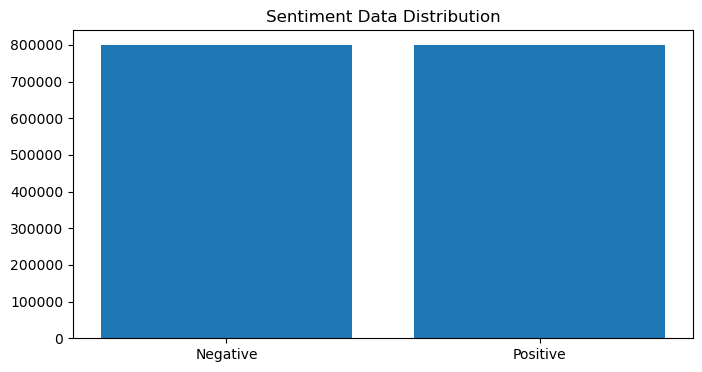

In [6]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
import random
random_idx_list = [ random.randint(1, len(df.text)) for i in range(10)]

df.loc[random_idx_list,:].head(10)

,sentiment,text
954985,Positive,@mitchelmusso My Saturday was AMAZING
460277,Negative,Murphy strikes again. VPN down.
1163548,Positive,7 down...1 to go! yaaaaaaaaaaaaaaaay!!
1570991,Positive,@klarinetchick03 Keep us posted! @hellspearx17
304467,Negative,@audreypanda My feelings are hurt.
601707,Negative,Has only 6 more days to go at Disney
1323627,Positive,@misha11 Just below the search box there shoul...
336243,Negative,did a stupid thing last night...
751290,Negative,Ugh. Made it to the gym without shoes.
980947,Positive,Chavs+Talking/Shouting+Jeremy Kyle=Good Times


### nettoyage des tweets

##### Stemming/Lemmatization

Radicalisation de mots : Les mots devront être réduits à leur forme radicale. Par exemple, "discount", "discounts", "discounted" et "discounting" devront être tous remplacé par " discount", et "include", "includes", "included", et "ncluded" devront être tous remplacés par « includ ». 

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

Hyperlinks and Mentions

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

In [9]:
def nettoyage(text, stem=True):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: nettoyage(x))

In [11]:
df.head(20)

,sentiment,text
0,Negative,awww bummer shoulda got david carr third day
1,Negative,upset updat facebook text might cri result sch...
2,Negative,dive mani time ball manag save rest go bound
3,Negative,whole bodi feel itchi like fire
4,Negative,behav mad see
5,Negative,whole crew
6,Negative,need hug
7,Negative,hey long time see yes rain bit bit lol fine thank
8,Negative,nope
9,Negative,que muera


##### Positive Words

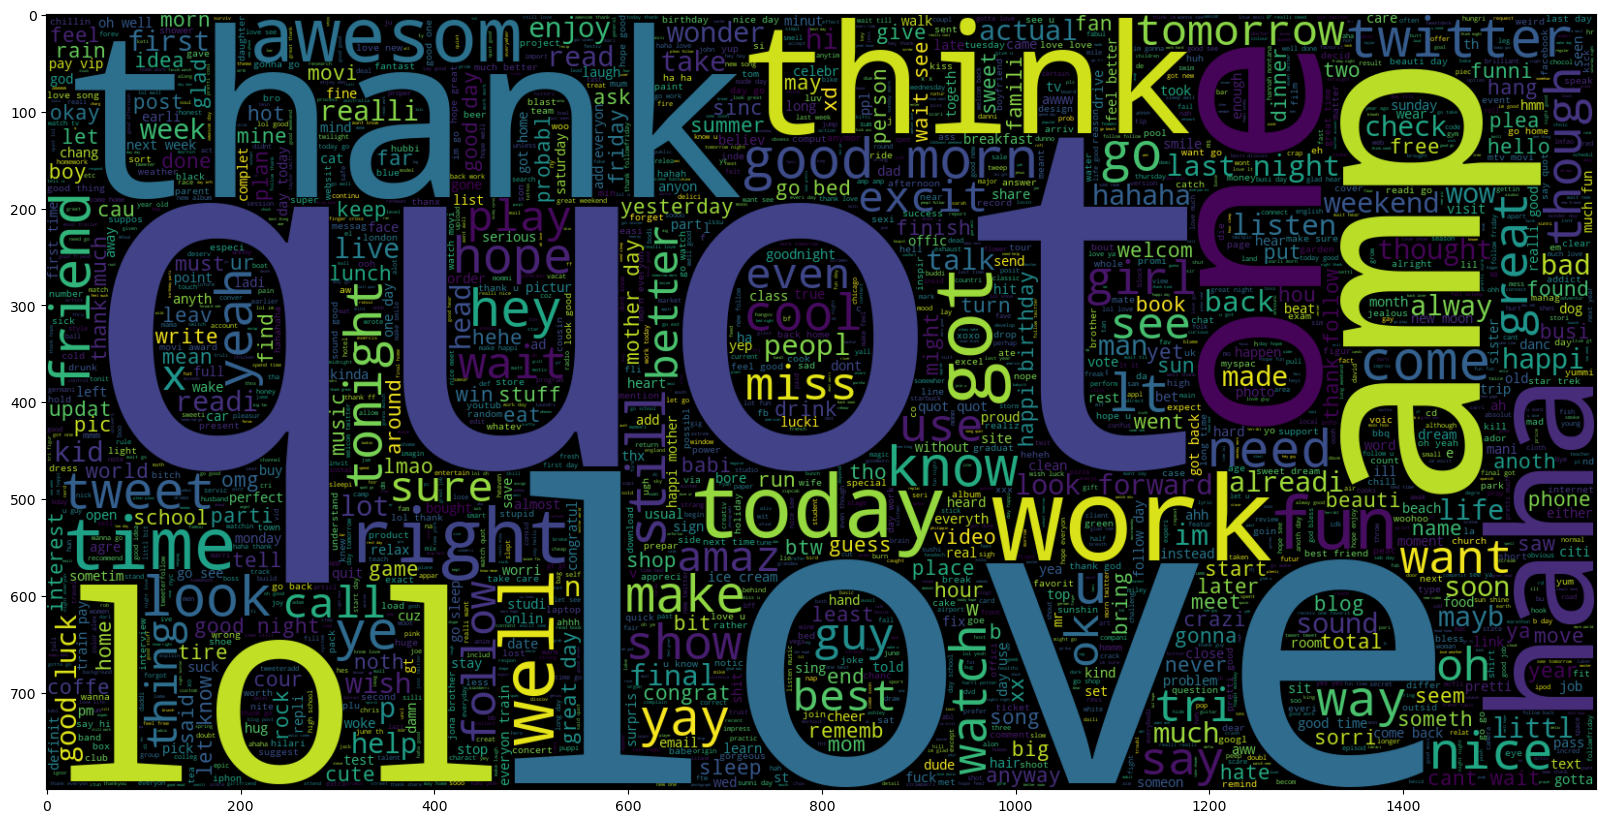

In [12]:
from wordcloud import WordCloud

plt.figure(figsize= (20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc, interpolation= 'bilinear')

##### Negative Words

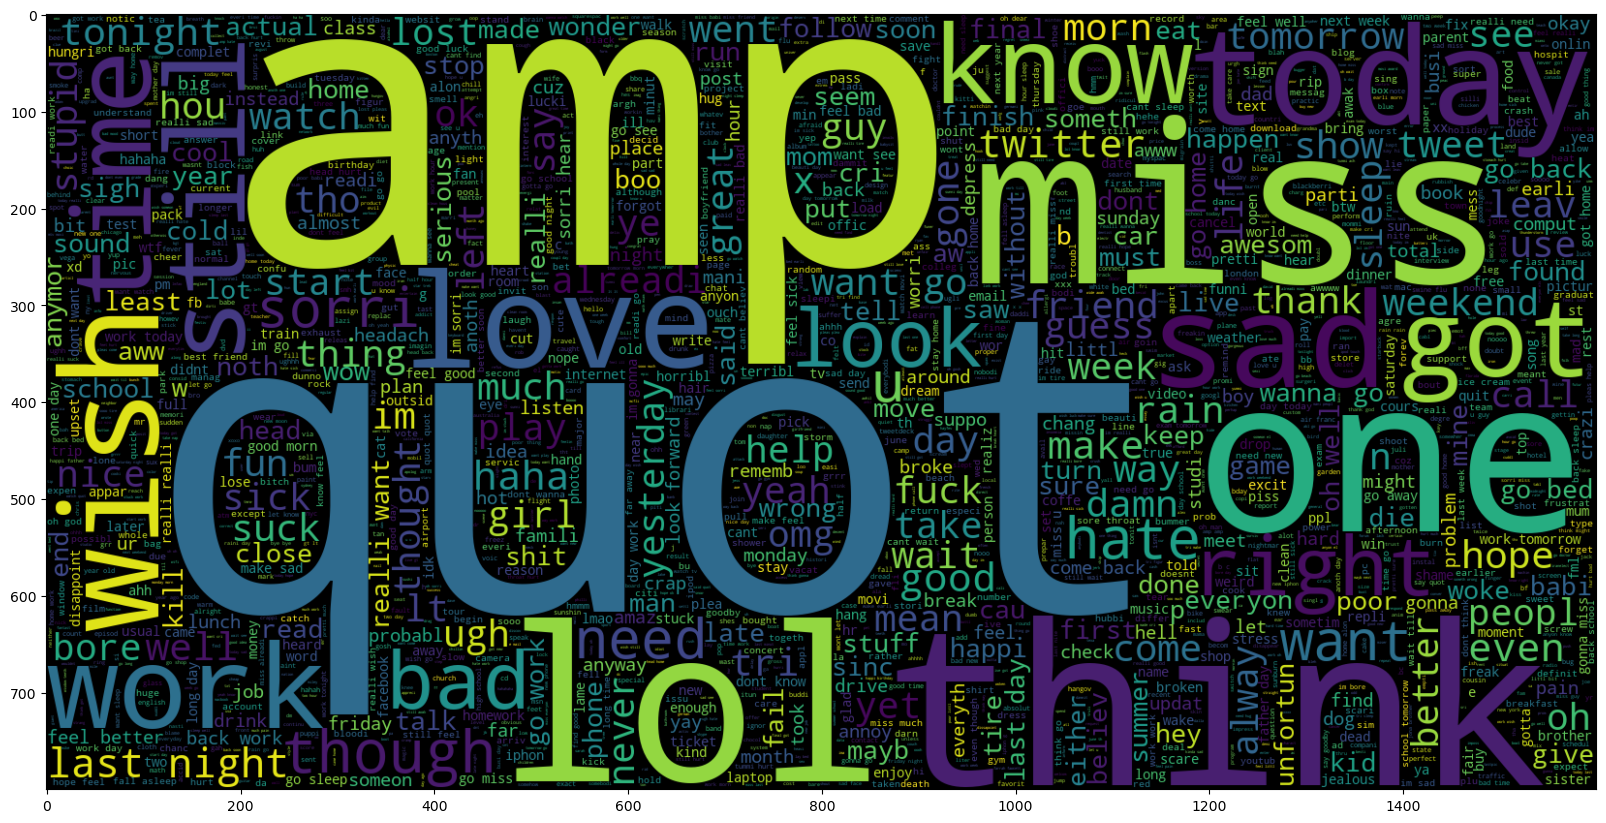

In [13]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc, interpolation= 'bilinear')

##### Train and Test Split

In [14]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30 

In [15]:
train_set, test_set = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train set size:", len(train_set))
print("Test set size:", len(test_set))

Train set size: 1280000
Test set size: 320000


In [16]:
train_set.head(10)

,sentiment,text
23786,Negative,need friend
182699,Negative,im tri call imposs
476661,Negative,good pace go k min miss k turn end k wave thru
1181490,Positive,u gonna show ny soon luv see u live
878773,Positive,hell yea get em tattoo ink free wish parent li...
130866,Negative,yeah need see ur mom call back first remembr s...
1235876,Positive,sound like cup tea sign
717314,Negative,tire want sleep wtf
969880,Positive,amaz wish
748698,Negative,thank god wkrn abc affili nashvill back miss s...


##### Construction du vocabulaire 

###### 1. Tekonization

In [17]:
from keras_preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_set.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  233069


In [ ]:
for word, index in tokenizer.word_index.items():
     print(index, word)

##### Extraction des caracteristiques (Représentation binaire)
Pour cette maniere de proceder pour allons declarer une matrice creuse, avec les lignes qui represente les tweets et les colonnes qui represente les mots du vocabulaire 

In [60]:
from scipy.sparse import lil_matrix

matrix = lil_matrix((len(train_set), vocab_size), dtype=int)

for i, tweet in enumerate(train_set.text):
     words = tweet.split()
     for word in words:
          if word in word_index:
               index = word_index[word]
               matrix[i, index] = 1

In [63]:
for i in range(matrix.shape[0]):
    print(matrix[i].toarray())

In [19]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen= MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_set.text), maxlen= MAX_SEQUENCE_LENGTH)
print("Training X shape: ", x_train.shape)
print("Testing X shape: ", x_test.shape)

Training X shape:  (1280000, 30)
Testing X shape:  (320000, 30)


In [20]:
print(x_train)
# df = pd.DataFrame(data=x_train.astype(int))
# df.to_csv('x_train_encoded.csv', sep=' ', header=False, index=False)

[[   0    0    0 ...    0   30   57]
 [   0    0    0 ...   52  111 2059]
 [   0    0    0 ...  449 1214 1041]
 ...
 [   0    0    0 ...  134 1123  219]
 [   0    0    0 ...    4   10  108]
 [   0    0    0 ...  632 1267 1591]]


###### 1.1 Label encoding

In [21]:
labels = train_set.sentiment.unique().tolist()

In [22]:
encoder = LabelEncoder()
encoder.fit(train_set.sentiment.to_list())

y_train = encoder.transform(train_set.sentiment.to_list())
y_test = encoder.transform(test_set.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (1280000, 1)
y_test shape:  (320000, 1)


In [23]:
# import subprocess
# subprocess.run(['unzip', 'glove.6B.zip'])

###### 2.  Word embedding

In [24]:
GLOVE_EMB = 'glove.6B/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = ''

In [25]:
embedding_index = {}

f = open(GLOVE_EMB, encoding='utf-8')
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [61]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0073678   0.062532   -0.097432   ... -0.32431999  0.19611
   0.29361999]
 [-0.14124    -0.11836    -0.30781999 ... -0.19882999 -0.061105
   0.11568   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [27]:
# embedding_layer = tf.keras.layers.Embedding(vocab_size) dimension and length must be specified 

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length=MAX_SEQUENCE_LENGTH,
                                            trainable=False)


[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0073678   0.062532   -0.097432   ... -0.32431999  0.19611
   0.29361999]
 [-0.14124    -0.11836    -0.30781999 ... -0.19882999 -0.061105
   0.11568   ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


## Classification 

### Machine Learning Classifiers 

#### SVM 

In [28]:
# in the examples on internet I noticed that most of them used linear kernal 
# ( we should check our accuracy if it is good we keep it linear otherwise use no linear kernal and set parameters)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM Model 
svm_model = SVC(kernel='linear', C=1.0)

# Train 
svm_model.fit(x_train, y_train.ravel())

# Predict
y_pred = svm_model.predict(x_test)

# Accuracy 
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

# Cross validation 
# estimations for the model (helps in parameters setting)
cv_scores = cross_val_score(svm_model, x_train, y_train.ravel(), cv=k)
print("Cross-Validation Scores:", cv_scores)
mean_cv_score = cv_scores.mean()
std_cv_score = cv_scores.std()
print("Mean Cross-Validation Score:", mean_cv_score)
print("Standard Deviation of Cross-Validation Scores:", std_cv_score)


#### Naive Bayes 

LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Convert text data to vectors
# using Embedding cant work with that data directly so better use vectorisation 
# needs to be checked 

# vectorizer = CountVectorizer()
# x_train = vectorizer.fit_transform(train_set['text'])
# x_test = vectorizer.transform(test_set['text'])



# Naive Bayes model
#can use makepipeline ( takes vectoriser and the NB model)
nb_model = MultinomialNB()

# Train the model
nb_model.fit(x_train, y_train.ravel())

# Predict
y_pred_nb = nb_model.predict(x_test)

# Accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)




#### Comparaison 
Temps d'execution and Accuracy 

### Deep Learning Classifiers 

#### LSTM 

In [ ]:
### Deep Learning Classifiers 

### Comparison between the ML and DL classifiers 